# Navigation Control A - Analyses

# Analyses

In [1]:
from scipy import stats 
from functools import lru_cache
import json
import pandas as pd
import seaborn as sns
from msdm.domains import GridWorld
from vgc_project import gridutils, utils

In [2]:
survey_trials = pd.read_json("./data/all-survey-trials.json")
attn_trials = pd.read_json("./data/all-attention-trials.json")
bc_trials = pd.read_json("./data/all-nav-trials.json")

#apply exclusions
survey_trials = survey_trials[~survey_trials.exclude].reset_index(drop=True)
attn_trials = attn_trials[~attn_trials['exclude_trial'] & attn_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
bc_trials = bc_trials[~bc_trials['exclude_trial'] & bc_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)

## Compare with Experiment 1

In [3]:
EXP1_NAV_FILE = "../exp1/data/results/navtrials.json"
EXP1_ATTN_FILE = "../exp1/data/results/attentiontrials.json"
exp1_at = pd.read_json(open(EXP1_ATTN_FILE, 'r'))
exp1_nt = pd.read_json(open(EXP1_NAV_FILE, 'r'))
basegrids = json.load(open("../mazes/mazes_0-11.json", 'r'))

In [4]:
# get navdist matrics
@lru_cache()
def make_gridworld(tile_array):
    return GridWorld(tile_array)

def calc_obs_traj_dist(grid, obs, traj):
    obs_locs = make_gridworld(tuple(basegrids[grid])).feature_locations[obs]
    return gridutils.min_dist(obs_locs, traj)["mindist"]

def calc_nav_dist_exp6(row):
    grid = row.grid
    traj = [t['state'] for t in row.navigationData]
    res = {}
    for obs in "0123456789":
        try:
            res[obs] = calc_obs_traj_dist(grid, obs, traj)
        except KeyError:
            continue
    return pd.Series(res)
def calc_nav_dist_exp1(row):
    grid = row.grid
    res = {}
    traj = [tuple(t) for t in row.traj]
    for obs in "0123456789":
        try:
            res[obs] = calc_obs_traj_dist(grid, obs, traj)
        except KeyError:
            continue
    return pd.Series(res)
    
exp6a_nav_dist = bc_trials.apply(calc_nav_dist_exp6, axis=1)
exp6a_nav_dist = \
    pd.concat([
        bc_trials[['sessionId', 'grid', 'round']],
        exp6a_nav_dist
    ], axis=1).\
    melt(
        id_vars=['sessionId', 'grid', 'round'],
        var_name="obstacle",
        value_name="nav_mindist"
    )
exp1_nt['grid'] = exp1_nt['grid'].apply(lambda gi: f"grid-{gi}-0")
exp1_trajs = exp1_nt.groupby(['round', 'grid', 'sessionId']).apply(lambda rs: pd.Series({"traj": list(rs.sort_values('trialnum')['state'])})).reset_index()
exp1_nav_dist = exp1_trajs.apply(calc_nav_dist_exp1, axis=1)
exp1_nav_dist = \
    pd.concat([
        exp1_trajs[['sessionId', 'grid', 'round']],
        exp1_nav_dist
    ], axis=1).\
    melt(
        id_vars=['sessionId', 'grid', 'round'],
        var_name="obstacle",
        value_name="nav_mindist"
    )

In [5]:
#check that the mean navdists are almost the same
nav_mindists = pd.concat([
    exp6a_nav_dist.groupby(['grid', 'obstacle'])['nav_mindist'].mean(),
    exp1_nav_dist.groupby(['grid', 'obstacle'])['nav_mindist'].mean()
], axis=1)
nav_mindists.columns = ['exp6a', 'exp1']
assert .99 < stats.pearsonr(nav_mindists.exp6a, nav_mindists.exp1)[0] < 1.0

<AxesSubplot:xlabel='exp6a', ylabel='exp1'>

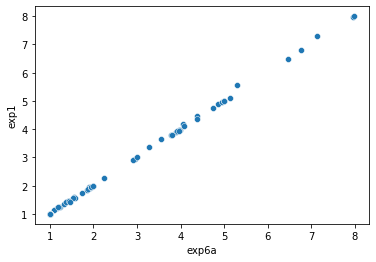

In [6]:
sns.scatterplot(data=nav_mindists, x='exp6a', y='exp1')

In [7]:
#combine attention w navdists
exp1_at['obstacle'] = exp1_at['probeobs']
exp1_at.grid = exp1_at.grid.apply(lambda gi: f"grid-{gi}-0")
exp1_at = exp1_at[['round', 'grid', 'obstacle', 'sessionId', 'attention']].reset_index(drop=True)
exp1_at['obstacle'] = exp1_at['obstacle'].apply(str)
exp1_at = exp1_at.merge(exp1_nav_dist, on=['sessionId', 'round', 'grid', 'obstacle'])

#scale
x = exp1_at['attention'].values
x[x > 0] = x[x > 0] - 1
exp1_at['attention'] = x + 5

exp6a_at = attn_trials[['round', 'grid', 'obstacle','sessionId', 'attn_resp']].rename(columns={'attn_resp':'attention'}).reset_index(drop=True)
exp6a_at['obstacle'] = exp6a_at['obstacle'].apply(str)
exp6a_at = exp6a_at.merge(exp6a_nav_dist, on=['sessionId', 'round', 'grid', 'obstacle'])

#check that they have same "support"
assert set(exp1_at['attention'].unique()) == set(exp6a_at['attention'].unique())
assert set(exp1_at['obstacle'].unique()) == set(exp6a_at['obstacle'].unique())
assert set(exp1_at['grid'].unique()) == set(exp6a_at['grid'].unique())

In [8]:
# combine attn into a single dataframe
comp_at = pd.concat([
    exp1_at.assign(exp="exp1"),
    exp6a_at.assign(exp="exp6a")
]).reset_index(drop=True)

In [9]:
from vgc_project.modelinterface import create_modeling_interface
from vgc_project import utils

mods = create_modeling_interface(joblib_cache_location="../../experiments/_analysiscache")
model_preds = []
for _, (gn, obs) in comp_at[['grid', 'obstacle']].iterrows():
    model_preds.append(mods.predictions(tuple(basegrids[gn]), obs, seed=72193880))
    
comp_at = pd.concat([
    comp_at,
    pd.DataFrame(model_preds)
], axis=1)
comp_at['neg_nav_mindist'] = -comp_at['nav_mindist']

to_zscore = [
    'vgc_weight',
    'value_mix_weight',
    'graph_based_hitcount', 'goal_dist',
    'start_dist', 'optpolicy_dist', 'walls_dist', 'center_dist',
    'bottleneck_dist', 'sr_occ',
    'log_traj_based_hitcount', 'nav_mindist', 'neg_nav_mindist'
]
for col in to_zscore:
    comp_at[col+"_Z"] = utils.zscore(comp_at[col])
comp_at['attention_N'] = utils.normalize(comp_at['attention'])

In [10]:
comp_at.columns

Index(['round', 'grid', 'obstacle', 'sessionId', 'attention', 'nav_mindist',
       'exp', 'vgc_weight', 'log_traj_based_hitcount', 'graph_based_hitcount',
       'goal_dist', 'start_dist', 'optpolicy_dist', 'walls_dist',
       'center_dist', 'value_mix_weight', 'bottleneck_dist', 'sr_occ',
       'neg_nav_mindist', 'vgc_weight_Z', 'value_mix_weight_Z',
       'graph_based_hitcount_Z', 'goal_dist_Z', 'start_dist_Z',
       'optpolicy_dist_Z', 'walls_dist_Z', 'center_dist_Z',
       'bottleneck_dist_Z', 'sr_occ_Z', 'log_traj_based_hitcount_Z',
       'nav_mindist_Z', 'neg_nav_mindist_Z', 'attention_N'],
      dtype='object')

In [11]:
# check that all obstacles and most grids are in comp_at
assert comp_at.groupby(['sessionId', 'grid'])['obstacle'].apply(lambda os: set(os) == set('0123456')).all()
assert comp_at.groupby(['sessionId'])['grid'].apply(lambda gs: len(set(gs)) > 12*.8).all()

In [12]:
%load_ext rpy2.ipython

In [13]:
%%R
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [14]:
%%R -i comp_at
# use sum coding for experiment comparison
comp_at$exp <- factor(comp_at$exp)
contrasts(comp_at$exp) <- contr.sum(2)
print(contrasts(comp_at$exp))

      [,1]
exp1     1
exp6a   -1


In [15]:
%%R
full <- lmer(
    attention_N ~ (1 | sessionId) + exp*vgc_weight_Z,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    data=comp_at,
    REML=F
)
print(anova(
    update(full, ~ . - exp:vgc_weight_Z),
    full
))
summary(full)

Data: comp_at
Models:
update(full, ~. - exp:vgc_weight_Z): attention_N ~ (1 | sessionId) + exp + vgc_weight_Z
full: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
                                    Df    AIC    BIC  logLik deviance  Chisq
update(full, ~. - exp:vgc_weight_Z)  5 7713.3 7754.3 -3851.7   7703.3       
full                                 6 7593.0 7642.2 -3790.5   7581.0 122.31
                                    Chi Df Pr(>Chisq)    
update(full, ~. - exp:vgc_weight_Z)                      
full                                     1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: attention_N ~ (1 | sessionId) + exp * vgc_weight_Z
   Data: comp_at
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+07))

     AIC      BIC   logLik deviance df.resid 
  7593.0   7642.2  -3790.5   7581.0    26769 

Scaled residu

In [16]:
%%R
full <- lmer(
    attention_N ~ (1 + round | sessionId) + (1 | grid) + 
        exp*(
            vgc_weight_Z + 
            graph_based_hitcount_Z + 
            log_traj_based_hitcount_Z + 
            value_mix_weight_Z + 
            goal_dist_Z + 
            start_dist_Z + 
            walls_dist_Z + 
            center_dist_Z + 
            bottleneck_dist_Z + 
            sr_occ_Z + 
            neg_nav_mindist_Z
        )
    ,
    data=comp_at,
    control=lmerControl(optimizer="bobyqa",optCtrl=list(maxfun=1e+07)),
    REML=F
)
lesioned <- update(full, ~ . - exp:vgc_weight_Z)
print(anova(
    lesioned,
    full
))
summary(full)

Data: comp_at
Models:
lesioned: attention_N ~ (1 + round | sessionId) + (1 | grid) + exp + vgc_weight_Z + 
lesioned:     graph_based_hitcount_Z + log_traj_based_hitcount_Z + value_mix_weight_Z + 
lesioned:     goal_dist_Z + start_dist_Z + walls_dist_Z + center_dist_Z + 
lesioned:     bottleneck_dist_Z + sr_occ_Z + neg_nav_mindist_Z + exp:graph_based_hitcount_Z + 
lesioned:     exp:log_traj_based_hitcount_Z + exp:value_mix_weight_Z + 
lesioned:     exp:goal_dist_Z + exp:start_dist_Z + exp:walls_dist_Z + exp:center_dist_Z + 
lesioned:     exp:bottleneck_dist_Z + exp:sr_occ_Z + exp:neg_nav_mindist_Z
full: attention_N ~ (1 + round | sessionId) + (1 | grid) + exp * (vgc_weight_Z + 
full:     graph_based_hitcount_Z + log_traj_based_hitcount_Z + value_mix_weight_Z + 
full:     goal_dist_Z + start_dist_Z + walls_dist_Z + center_dist_Z + 
full:     bottleneck_dist_Z + sr_occ_Z + neg_nav_mindist_Z)
         Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
lesioned 28 156.05 385.52 

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




# Visualizations

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

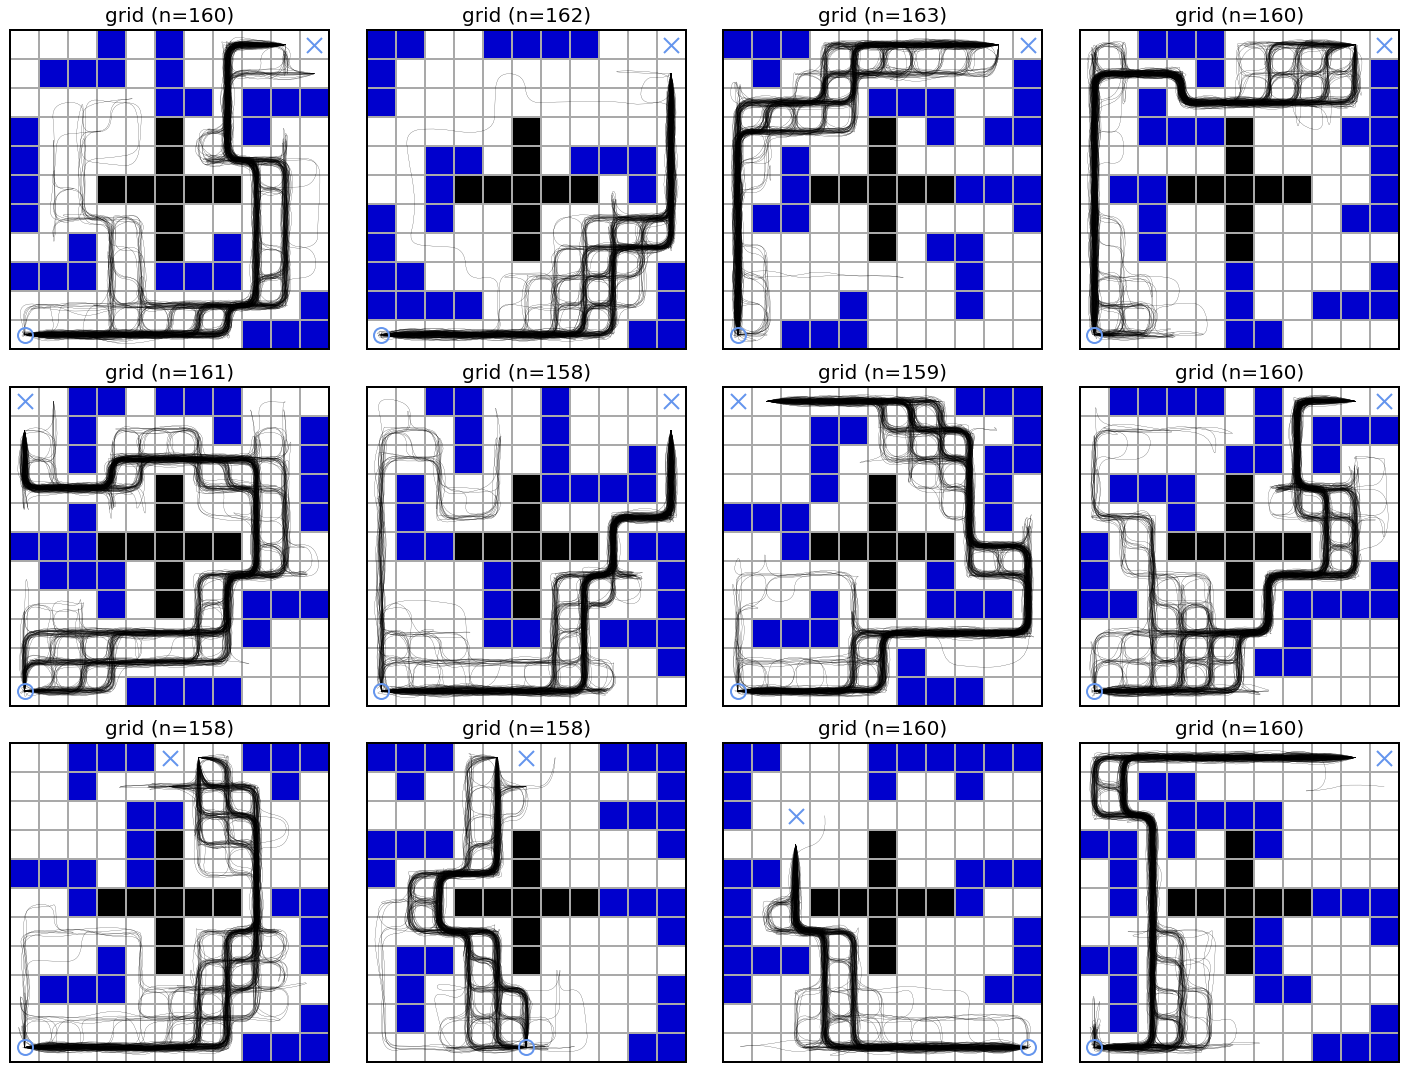

In [18]:
n_grids = len(bc_trials.grid.unique())
nrows = 3
ncols = n_grids // nrows
mult = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*mult, nrows*mult))
axes = list(axes.flatten())
for grid, rows in bc_trials.groupby("grid"):
    gw = GridWorld(
        tile_array=basegrids[grid],
        absorbing_features="G",
        initial_features="S"
    )
    ax = axes.pop(0)
    gwp = gw.plot(ax=ax, featurecolors={**{f: "mediumblue" for f in "0123456789"}, "#": "k"})
    for _, row in rows.iterrows():
        gwp.plot_trajectory([t['state'] for t in row.navigationData], lw=.2)
    gwp.title(f"grid (n={len(rows)})", fontsize=20)
plt.tight_layout()

In [19]:
mediumblue = np.array(to_rgb('mediumblue'))
gainsboro = np.array(to_rgb('gainsboro'))

def color_mix(v, alpha=12):
    w = 1/(1 + np.exp(-alpha*(v-.5)))
    return (1-w)*gainsboro + w*mediumblue

def plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=False, number_fontsize=15, number_format="f"):
    fc = {o: color_mix((v - vmin)/(vmax - vmin)) for o, v in values.items()}
    gw = GridWorld(tile_array, absorbing_features=('G', ), initial_features=('S',))
    start = gw.initial_states[0]
    goal = gw.absorbing_states[0]
    gwp = gw.plot(featurecolors=fc, ax=ax, plot_initial_states=False, plot_absorbing_states=False).\
        annotate(start, text="S", fontsize=30, fontfamily="Courier New", weight='bold').\
        annotate(goal, text="G", fontsize=30, fontfamily="Courier New", weight='bold')
    if show_numbers:
        marked = []
        for loc, f in gw.location_features.items():
            if (f in fc) and (f not in marked):
                marked.append(f)
                if number_format == 'f':
                    if 0 < values[f] < 1.0:
                        text = f"{values[f]:.2f}".lstrip("0")
                    else: 
                        text = f"{values[f]:.1f}"
                elif number_format == 'g':
                    text = ("%.2g" % values[f]).replace("-0","-").lstrip("0")
                gwp.annotate(loc, 
                             text=text,
                             fontsize=number_fontsize,
                             weight='bold',
                             color='w' if ((values[f] - vmin)/(vmax - vmin)) > .5 else 'k')
        
    if title:
        gwp.title(f"{title}", fontsize=30)

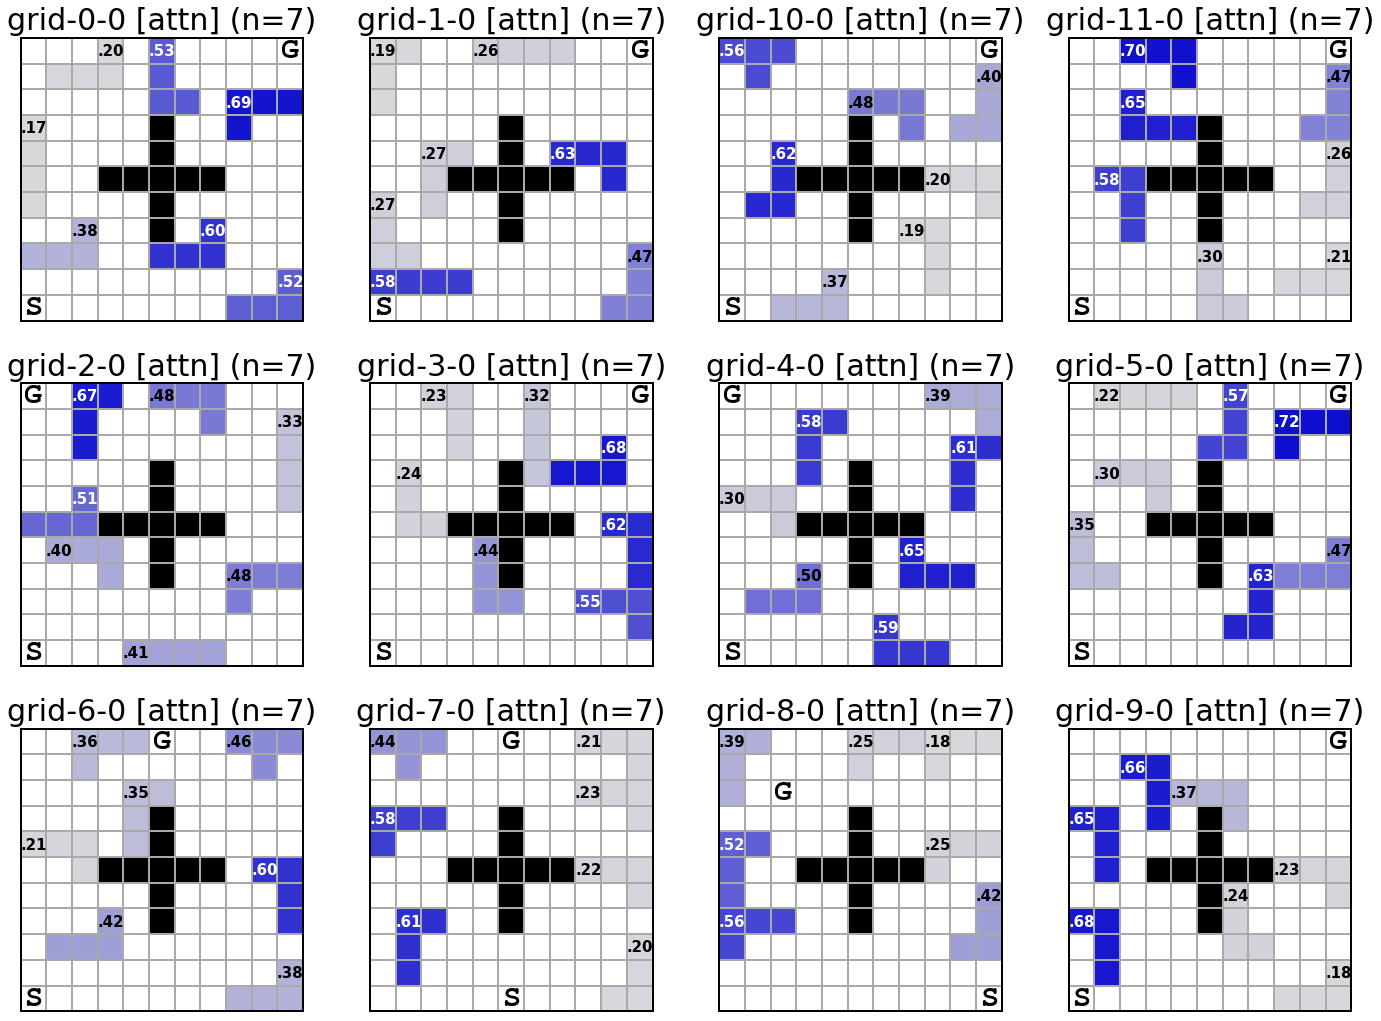

In [20]:
to_plot = attn_trials.groupby(['grid', 'obstacle'])['attn_resp_N'].agg(['mean', 'sem', 'count']).reset_index()
nrows = 3
ncols = 4
mul=6
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*mul, nrows*mul))
axes = list(axes.flatten())
for grid, rows in to_plot.groupby('grid'):
    tile_array = basegrids[grid]
    values = dict(zip([str(o) for o in rows.obstacle.values], rows['mean'].values))
    ax = axes.pop(0)
    title = f"{grid} [attn] (n={len(rows)})"
    plot_obstacle_values(tile_array, values, ax, title,
                         vmin=0, vmax=1, invert=False,
                         show_numbers=True, number_fontsize=15, number_format="f")